In [31]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

In [32]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):  # 그래프 그리는 함수(시각화)
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [34]:
# dataset 로드
# IMDB large movie review dataset은 긍정리뷰를 1로, 부정리뷰를 0으로 라벨링 해두었다.
dataset, info = tfds.load('imdb_reviews', with_info = True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

In [35]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [36]:
BUFFER_SIZE = 10000  # 1 epoch 되는 데이터 수
BATCH_SIZE = 64   # 1 step에서 사용되는 데이터 수

In [37]:
# 훈련용 data를 섞는다.
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [38]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"After the opening credits, there's a black screen for about a minute. A minute of nothing, then a girl wakes up and takes a shower.Then her and two college friends are driving to a rock concert, after much padding, they hit something and skid off the road. They awaken in a cabin inhabited by a wheelchair-bound old lady and her offspring.The killings are sadly very tame for a supposed Video Nasty. The twist ending silly and predictable. No one involved in the mess would ever make anything of note again. So there are still happy endings sometimes.<br /><br />Eye Candy: Sara Ansley gets topless, and Laurel Munson has full frontal on display <br /><br />My Grade: D"
 b'Gordon Parks, the prolific black Life magazine photographer, made a true ticking-timebomb of a movie here - one that does not mess around! Based upon the true story of two NYC cops - later dubbed Batman and Robin - who singlehandedly employed radical tactics to clean up their precinct neighborhood of drugs, this i

In [39]:
VOCAB_SIZE = 1000

# TextVectorization 레이어를 통해 텍스트 전처리를 진행한다.
# TextVectorizTION은 문자열 토큰과 정수 인덱스 간의 매핑을 가진다.
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)

# adapt는 layer의 어휘를 설정한다.
tokenizer.adapt(train_dataset.map(lambda text, label: text))

In [40]:
# 패딩 및 알 수 없는 토큰 다음에 빈도별로 정렬된다.
vocab = np.array(tokenizer.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [41]:
# 어휘가 설정이 되면, layer는 텍스트를 인덱스로 인코딩 할 수 있다.
# 길이가 짧은 경우, 뒷 부분에 남는 부분은 0으로 채워진다.

tokenized_example = tokenizer(example)[:3].numpy()
tokenized_example

array([[101,   2, 615, ...,   0,   0,   0],
       [  1,   1,   2, ...,   0,   0,   0],
       [ 10,  86, 208, ...,   0,   0,   0]])

In [42]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[tokenized_example[n]]))
  print()

Original:  b"After the opening credits, there's a black screen for about a minute. A minute of nothing, then a girl wakes up and takes a shower.Then her and two college friends are driving to a rock concert, after much padding, they hit something and skid off the road. They awaken in a cabin inhabited by a wheelchair-bound old lady and her offspring.The killings are sadly very tame for a supposed Video Nasty. The twist ending silly and predictable. No one involved in the mess would ever make anything of note again. So there are still happy endings sometimes.<br /><br />Eye Candy: Sara Ansley gets topless, and Laurel Munson has full frontal on display <br /><br />My Grade: D"
Round-trip:  after the opening credits theres a black screen for about a minute a minute of nothing then a girl [UNK] up and takes a [UNK] her and two [UNK] friends are [UNK] to a rock [UNK] after much [UNK] they hit something and [UNK] off the [UNK] they [UNK] in a [UNK] [UNK] by a [UNK] old lady and her [UNK] [UN

In [43]:
# model 생성

model = tf.keras.Sequential([
    tokenizer, # 첫번째 층인 encoder는 text를 token index들로 바꾼다

    #임베딩 레이어
    #임베딩 레이어는 단어 하나당 하나의 벡터를 저장한다.
    #호출 시, 단어 인덱스 시퀀스를 벡터 시퀀스로 변환한다.
    #훈련 이후, 유사한 의미를 가지는 단어는 유사한 벡트를 가지게 된다.
    tf.keras.layers.Embedding(
        input_dim=len(tokenizer.get_vocabulary()),
        output_dim=64,
        mask_zero=True),

    # 68개의 hidden unit을 가진 LSTM layer
    tf.keras.layers.LSTM(64),

    # 마지막 layer는 classification을 진행한다.
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [44]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [45]:
# predict on a sample text without padding.
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[-0.00764967]


In [46]:
# predict on a sample text with padding -- 위의 cell과 결과가 동일하게 나와야 한다.
padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[-0.00764967]


In [47]:
# model 컴파일
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [48]:
# 학습 진행
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 23s 48ms/step - loss: 0.6456 - accuracy: 0.5767 - val_loss: 0.6778 - val_accuracy: 0.6609
Epoch 2/10
391/391 [==============================] - 18s 45ms/step - loss: 0.5149 - accuracy: 0.7580 - val_loss: 0.4393 - val_accuracy: 0.7958
Epoch 3/10
391/391 [==============================] - 18s 45ms/step - loss: 0.3953 - accuracy: 0.8232 - val_loss: 0.3764 - val_accuracy: 0.8224
Epoch 4/10
391/391 [==============================] - 18s 46ms/step - loss: 0.3501 - accuracy: 0.8499 - val_loss: 0.3523 - val_accuracy: 0.8474
Epoch 5/10
391/391 [==============================] - 18s 45ms/step - loss: 0.3298 - accuracy: 0.8618 - val_loss: 0.3437 - val_accuracy: 0.8443
Epoch 6/10
391/391 [==============================] - 19s 46ms/step - loss: 0.3184 - accuracy: 0.8649 - val_loss: 0.3374 - val_accuracy: 0.8500
Epoch 7/10
391/391 [==============================] - 18s 45ms/step - loss: 0.3118 - accuracy: 0.8696 - val_loss: 0.3379 - val_accuracy:

In [49]:
# 모델 실행 결과
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 12s 29ms/step - loss: 0.3173 - accuracy: 0.8601
Test Loss: 0.31730416417121887
Test Accuracy: 0.8601199984550476


실행 결과  
Test Loss: 0.31730416417121887  
Test Accuracy: 0.8601199984550476

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

실행결과  
(0.0, 0.696526862680912)  

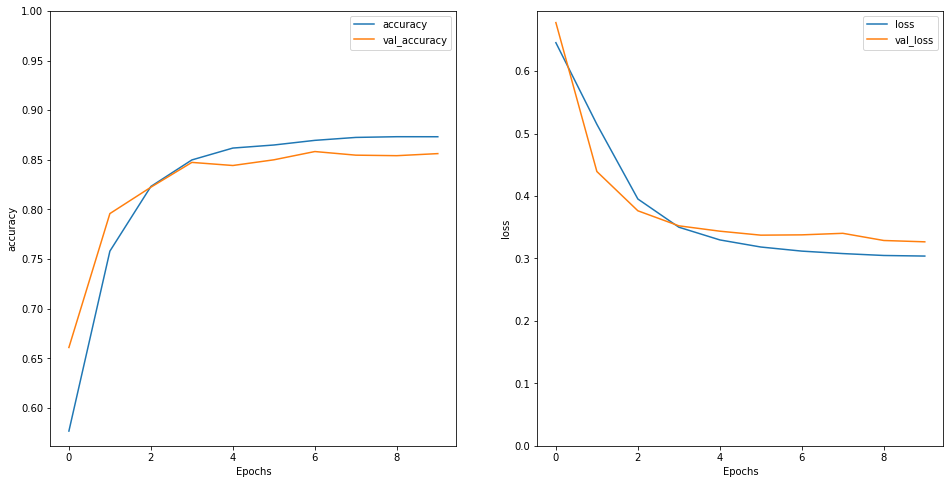

In [51]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[0.5182748]]


새 문장에 대한 예측 실행 결과를 보면, predictions이 0 이상이면 긍정이고 그렇지 않으면 부정이다.  

넣은 data(sample_text)가 읽어봤을 때 긍정적인 내용이므로 0 이상의 결과가 나와야 한다.


---



실행결과 => [[0.5182748]]  
실행결과가 0 이상으로 잘 나오는 것을 확인할 수 있다.